## Importing Libraries

Importing pandas for data handling, and numpy for math <br>
Using Plot style fivethirtyeight

In [1]:
# Importing libraries required to handle the data and matrix calculations
import pandas as pd
import numpy as np

# Importing libraries required for visualization
import matplotlib.pyplot as plt

# Importing libraries required for importing the data
from google.colab import files
import io

# For time measurements
import time

# Using plot style from fivethirtyeight
plt.style.use('fivethirtyeight')

## Neuron and Layers

* **Neuron Class:** The neuron class is just a representation of a neuron with a bias and some incoming weights

* **Neuron Layer Class:** The layer class initializes a fully connected layer (Dense layer)based on the inputs and the number of neurons in a layer, uses the Neuron base class for neuron representation

The weight initialization is from the standard normal distribution ~ N(0,1).

The Bias is initialized with 0.

The Neuron Layer has the following properties:
* The Weights matrix shape is : [inputs x number of neurons in this layer]
* The biases in a layer, we have one bias per neuron and so the shape is: 
[1 x number of neurons in this layer]
* The fire function: Takes in the inputs and fires the layer, i.e. calculates the weighted sum of incoming weights and the input, adds the bias to get the output for the layer. Also calculates the activation,a dn the gradient of the activation
* ReLU (Rectified Linear Unit) activation function: f(x) = {0 if x<= 0; and x if x > 0}
* ReLU gradient: Assuming the derivative for RelU at 0 is 0,a s it approaches 0
* Other helper functions for getting and setting weights and biases


In [2]:
class Neuron:
  def __init__(self, w = None, b = None):
    self.weights = w
    self.bias = b

  def update(self, w, b):
    self.weights = w
    self.bias = b

  def __repr__(self):
    return f"{{My Bias = {self.bias} | Incoming Weights: {self.weights}}}"

class NeuronLayer:
  # Every layer has an input vector (x: previous layer output shape (nodes)) and an output vector (y: This layer output shape (nodes/workers))
  def __init__(self,n_inputs,n_neurons, weights = [], biases = []):
    self.input_nodes = n_inputs # Nodes in the previous layer (as they are input to this layer)
    self.output_nodes = n_neurons # Nodes in the layer
    
    if len(weights) == 0: # If no weights were provided
      self.weights = np.random.rand(self.input_nodes,self.output_nodes)
    else:
      self.weights = weights

    if len(biases) == 0: # If no biases were provided
      # self.biases = np.random.randn(1,self.output_nodes)
      self.biases = np.zeros((1,self.output_nodes))
    else:
      self.biases = biases

    # Creating the specific layer with the weights and biases for the Neurons
    self.layer = [Neuron(w,b) for b,w in zip(self.biases[0], self.weights.T)]

  def fire(self,training_input,activationFunction, gradientFunction):
    self.output = np.dot(training_input, self.weights) + self.biases
    self.activated_output = np.array([[activationFunction(c) for c in r] for r in self.output])
    self.activation_gradient = np.array([[gradientFunction(c) for c in r] for r in self.output])

  # Using Rectified Linear Unit activation function, if the value is negative return 0 otherwise unchanged value
  # f(x) = {0 if x<= 0; and x if x > 0}
  # Implementation is just a max{0,value}
  def relu(self,x):
    return np.maximum(0,x)

  # The derivative for f(x) = {0 if x <= 0; and x if x > 0}
  # f'(x) = { 0 if x <= 0; and 1 if x > 0} assuming the derivative for relu at 0 is 0 (as its approaching 0)
  def reluGradient(self,x):
    if x <= 0:
      return 0
    return 1

  # Helper functions to adjust/update the weights and biases
  def getWeights(self):
    return self.weights
  def getBiases(self):
    return self.biases
  def setWeights(self,new_weights):
    self.weights = new_weights
  def setBiases(self,new_biases):
    self.biases = new_biases

  def updateLayer(self):
    for i,b,w in zip(range(self.output_nodes), self.biases[0], self.weights.T):
      self.layer[i].update(w,b) 

  def __repr__(self):
    return f"\n{self.layer}"

## Neural Network

The Neural Network class uses the Neuron layer class defined above to create a network of layers.

The input layer is created for representation purposes as it does nothing in the calculations as it has no incoming weights or biases.

The initialization of the Neural Network requires a list of neurons per layer, with the list provided the input, hidden and output layers are created.

The training of a neural network has 2 steps:
* Feed forward: In this step we just feed the data forward, starting from the provided input, the first hidden layer is given that input, the layer is fired where the activations are calculated, these output activation of this layer is used as the input for the next layer, and hence feed forward.

* Backpropagation: This is the main step where the error is calculated from the given labels and predicted output. With this error we calculate the gradient descent for the error (loss) function. 

The gradient descent for the output layer = 
error_derivative * activation_derivative

For weights: the Input to this layer is multiplied to get the weighted error based on the inputs, that is which input mattered more in this calculations and so which weights need to change more than others. It is then multiplied with learning rate to control the changes.

For biases: The gradient descent is summed up along the axis and then we have the biases per node based on the error and the learning rate.

Loss Functions:
Used basic squared error as it gives positive results, also tried mean squarred error and root mean squarred error.
The functions and their derivaties are used to calculate the gradient descent

The Fit Function: Takes input the whole training data, number of epochs, learning rate, error threshold and mini batch size.

Given these parameters, the fit function runs a loop for all the epochs.

    For every epoch:
      The training data is shuffled,
      The data is split into mini batches of the provided size,
      for every mini batch:
        We feed forward the mini batch and the error is calculated
        The error is backpropagated
    The netowrk weights and biases are updated once the training is complete.
    The fit method returns an array with errors for every epoch.

In [3]:
class NN:
  # layer_sizes format is a list of number of neurons per layer for example => [2,3,1] 2 input neurons, 3 hidden neurons and 1 output neuron
  def __init__(self,layer_sizes):
    # Network parameters initialization
    self.network_size = len(layer_sizes)
    self.input_nodes = layer_sizes[0]
    self.output_nodes = layer_sizes[self.network_size-1]
    self.hidden_layers = [None for _ in range(self.network_size-2)]
    self.layers = []

    # Initializing Network architecture/layers
    # For the provided structure we create the nodes/workers
    # The input layer is easy as it only has nodes for every input with no incomming weights and biases of its own
    # Creating this layer for representation purposes, doesnt have any work in the neural networks calculations
    self.input_layer = [Neuron() for _ in range(self.input_nodes)]
    
    # Creating Hidden layers
    for i in range(self.network_size -2): # Starting from 0 as input to first hidden layer is from the input layer
      self.hidden_layers[i] = NeuronLayer(layer_sizes[i],layer_sizes[i+1])
      self.layers.append(self.hidden_layers[i])

    # Creating Output Layer
    self.output_layer = NeuronLayer(layer_sizes[self.network_size-2],self.output_nodes)
    self.layers.append(self.output_layer)

  def epochRange(self, start, epochs):
    epoch = start
    while epoch < epochs:
      yield (epoch)
      epoch += 1

  def squaredError(self, predicted, true):
    error = 0.5*(true - predicted)**2
    return np.sum(error)

  def squaredGradient(self, predicted, true):
    return (true - predicted)

  # A mean squared cost function, takes the mean of the error term that is the squared diffrence between the predicted and expected value
  # mse = sum((x_true - x_predicted)^2)/2N = mean(0.5*(x_true - x_predicted)^2)
  def meanSquaredError(self,predicted,true):
    # Calculating the error
    error = true - predicted # [[predicted_i1, predicted_i2, ..., predicted_in]...] -[[true_i1, true_i2, ..., true_in]...] shape: rows=> number of samples in batch (b); col=> input features (n); => [b x n] matrix
    error = 0.5 * np.power(error, 2) # Squarred error [[error_sample1]**2,[error_sample2]**2, ..., [error_samplen]**2] => [b x n] matrix
    return np.mean(error) # Mean of the squared error within a batch, does nothing if batch size is 1 that is 1 sample at a time

  # The derivative of mse = sum((x_true - x_predicted)^2)/2N
  # mse' = (x_true - x_predicted)/N
  # Similar implementation as the mean squared error
  def mseGradient(self,predicted,true):
    error = true - predicted # [[predicted_i1, predicted_i2, ..., predicted_in]...] -[[true_i1, true_i2, ..., true_in]...] shape: number of samples in batch (b) x input features (n); => [b x n] matrix
    return error/true.size # Mean of the error within a batch, does nothing if batch size is 1 that is 1 sample at a time

  # Another cost function, takes the root of the mean squarred error
  def rootMeanSquaredError(self,predicted,true):
    # Calculating the error
    error = true - predicted # [[predicted_i1, predicted_i2, ..., predicted_in]...] -[[true_i1, true_i2, ..., true_in]...] shape: rows=> number of samples in batch (b); col=> input features (n); => [b x n] matrix
    error = np.power(error, 2) # Squarred error [[error_sample1]**2,[error_sample2]**2, ..., [error_samplen]**2] => [b x n] matrix
    return np.sqrt(np.mean(error)) # the square root of the mean squared error

  # The derivative for the rmse function
  def rmseGradient(self,predicted,true):
    return self.mseGradient(predicted,true)/(2*self.rootMeanSquarredError(predicted,true)) # d(rmse)/d(prev_activation) = (1/2*rmse)*mseGradient()
    
  def gradientDescent(self,error_gradient, activation_gradient):
    return error_gradient*activation_gradient

  def feedForward(self, training_batch):
    inp = training_batch # Input Layer

    for i in self.epochRange(0,self.network_size-2): # For every hidden layer (Total network layers - input layer - output layer)
      self.hidden_layers[i].fire(inp, self.hidden_layers[i].relu, self.hidden_layers[i].reluGradient)
      inp = self.hidden_layers[i].activated_output # Feeding the output forward as input
    
    # output layer (input is the output from the last layer (input/hidden layer))
    self.output_layer.fire(inp, self.output_layer.relu, self.output_layer.reluGradient)
    # print(f"Final output: {self.output_layer.activated_output}")

  # Going in reverse from the output layer to the first hidden layer in the network
  def backPropagation(self, training_batch, labels, lr, threshold, prev_error):
    # Calculating the error and the error gradient (the direction of the gradient ascent)
    error = self.squaredError(self.output_layer.activated_output,labels)
    error_gradient = self.squaredGradient(self.output_layer.activated_output,labels)
    # error = self.meanSquaredError(self.output_layer.activated_output,labels)
    # error_gradient = self.mseGradient(self.output_layer.activated_output,labels)

    # Calculating the asjustments for the output layer based on the error and the output layer activation gradient
    adjustments = self.gradientDescent(error_gradient, self.output_layer.activation_gradient)
    
    if self.network_size > 2: # If there is a hidden layer
      last_input = self.hidden_layers[-1].activated_output # The activated output of the last hidden layer
    else:
      last_input = training_batch # No hidden layer, the output layer is the only layer in the network

    # Calculating output layer adjustments based on the loss
    adjustments_wo = np.dot(last_input.T, adjustments) * lr
    output_bias = np.sum(adjustments,axis=0,keepdims=True) * lr

    adjustments_wh = []
    hidden_bias = []
    runCount = 0

    # For hidden layers, the adjustments from the previous layer is used and multiplied with the weights to get the gradient of cost with respect to the previous activation
    for i in range(self.network_size-3, -1, -1): # For every hidden layer (Total network layers - input layer - output layer)
      if runCount != 0:
        # Following hidden layers towards input layers
        adjustments = np.dot(adjustments, self.hidden_layers[i+1].weights.T)
        adjustments = adjustments * self.hidden_layers[i].activation_gradient
      else:
        # Last Hidden layer adjustments
        adjustments = np.dot(adjustments, self.output_layer.weights.T)
        adjustments = adjustments * self.hidden_layers[i].activation_gradient
        
      if i > 0: # If there are hidden layers
        last_input = self.hidden_layers[i-1].activated_output # The activated output of the previous hidden layer
      else: # First hidden layer takes the provided input
        last_input = training_batch # No hidden layer, the output layer is the only layer in the network

      runCount += 1
      adjustments_wh.append(np.dot(last_input.T, adjustments) * lr)
      hidden_bias.append(np.sum(adjustments,axis=0,keepdims=True) * lr)
      

    # Updating the weights and biases from the calculated adjustments
    self.output_layer.setWeights(self.output_layer.getWeights() + adjustments_wo)
    self.output_layer.setBiases(self.output_layer.getBiases() + output_bias)

    for i,wh,bh in zip(range(self.network_size-3, -1, -1),adjustments_wh,hidden_bias):
      self.hidden_layers[i].setWeights(self.hidden_layers[i].getWeights() + wh)
      self.hidden_layers[i].setBiases(self.hidden_layers[i].getBiases() + bh)

    return error

  def fit(self,X_train,labels,epochs, mini_batch_size = 32,learningRate = 1e-1, threshold = 1e-5):
    lr = learningRate # Learning rate
    error = np.zeros((epochs+1,1))
    error[0] = np.inf # Starting with a very high error,a nd minimizing this using gradient descent
    training_data = np.hstack((X_train,labels))
    n = len(training_data)
    for epoch in self.epochRange(1,epochs+1): # For every epoch
      print(f"Epoch: {epoch} => ", end = "")
      start = time.time()

      # Shuffling the data and creating mini batches
      np.random.shuffle(training_data)
      mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
      m_count = 0

      for mini_batch in mini_batches: # For every mini batch
        if m_count % mini_batch_size == 0:
          print(".", end="")
        training_batch = mini_batch[:,:-self.output_layer.output_nodes] # Shuffled X_train
        training_labels = np.array([mini_batch[:,-self.output_layer.output_nodes]]).T # Shuffled Y_train

        # Run the feed forward
        self.feedForward(training_batch)

        #Calculating error and backpropogating the updates
        error[epoch] += self.backPropagation(training_batch, training_labels, learningRate, threshold, error[epoch-1])
        m_count += 1

      end = time.time()
      print(f" => Error: {error[epoch,0]}; ", end = "")
      print(f"Time taken: {end - start} seconds")

    self.updateNetwork() # Updating the wholel network with the final weights and biases calculated
    return error[1:epoch+1]

  # Updates the network, sets the final values of the neuron after all backpropogation through every epoch. Only required for final representation of the network, as it updates all the neurons in every layer
  def updateNetwork(self):
    self.output_layer.updateLayer() # Updating the output layer neurons
    for i in self.epochRange(0,self.network_size-2): # For every hidden layer (Total network layers - input layer - output layer)
      self.hidden_layers[i].updateLayer() # Updating the hidden layer neurons

  def classify(self, x):
    if x >= 0.5:
      return 1
    return 0
  def __repr__(self):
    if self.network_size > 2:
      return f"Neural Network Architecture \n\nInput Layer=> \n{self.input_layer} \n\nHidden Layers=> {self.hidden_layers} \n\nOutput Layer=> {self.output_layer} \n"
    return f"Neural Network Architecture \n\nInput Layer=> \n{self.input_layer} \n\nOutput Layer=> {self.output_layer} \n"

##Loading and Pre-Processing the dataset

Reading the 5 Suites and 5 Cards and their respective class

Cleaning the dataset, Dropping rows with NA values and resetting index

Scaling the values for better training, and splitting into train and test datasets.

In [4]:
uploaded = files.upload()

Saving poker-hand-testing.data to poker-hand-testing.data
Saving poker-hand-training-true.data to poker-hand-training-true.data


In [5]:
training_path = io.BytesIO(uploaded['poker-hand-training-true.data'])
testing_path = io.BytesIO(uploaded['poker-hand-testing.data'])
df_train = pd.read_csv(training_path, header = None, names = ['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'Class'])
df_test = pd.read_csv(testing_path, header = None, names = ['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'Class'])
df_train = df_train.sample(frac=1).reset_index(drop=True) # Shuffling the training data

In [6]:
# Poker Hands dataset
df = df_train.copy()

target = 'Class'
predictors = list(df.columns)
predictors.remove(target)

suites = ['S1', 'S2', 'S3', 'S4', 'S5']
cards = ['C1', 'C2', 'C3', 'C4', 'C5']

suitesNorm = df_train['S1'].max() # Suite values=> [1,2,3,4] 
cardsNorm = df_train['C1'].max() # Card values=> [1,2,3,4,5,6,7,8,9,10,11,12,13]
classNorm = df_train['Class'].max() # Class values=> [0,1,2,3,4,5,6,7,8,9]

for s in suites: # => dividing by 4 => [0.25,0.5,0.75,1]
  df[s] = df[s]/suitesNorm

for c in cards: # dividing the values by 13 => so they are between [0,1]
  df[c] = df[c]/cardsNorm

# Scaling the target values in range [0,1]
df[target] = df[target]/classNorm

X = df[predictors].values # Scaled Features
y = np.array([df[target].values]).T # Target values

train_len = round(0.8*len(X)) # 80-20 split for train and test dataset
X_train = X[:train_len] # Features to train on
y_train = y[:train_len] # Target values for backpropagation

X_test = X[train_len:] # Features to test on
y_test = y[train_len:] # Target values for performance testing (accuracy/error)

df.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Class
0,0.75,0.461538,1.00,0.153846,1.00,0.538462,1.00,0.461538,0.50,0.461538,0.333333
1,0.50,0.461538,0.75,0.230769,1.00,0.153846,0.50,1.000000,0.25,0.538462,0.000000
2,0.75,0.692308,0.25,0.923077,1.00,1.000000,0.50,0.230769,0.50,0.076923,0.000000
3,0.75,0.307692,0.50,0.769231,0.75,0.230769,1.00,1.000000,1.00,0.307692,0.111111
4,0.75,0.769231,0.25,0.461538,1.00,0.615385,0.25,1.000000,0.25,0.384615,0.000000


## Training the Neural network

For the archtecture of this network I played around with many different combinations, increasing the number of nodes/width in the hidden layer (increasing the representaion dimension of the data) helped in lowering the error, also gradual increase in the number of layers/depth also helped with the error. So the final choice for the architecure of the network is as follows:

10 Neurons Input layer, 20 Neurons in the first hidden layer, 40 in the next hidden layer, then back to 20 in the next hidden layer, then back to 10 in the last hidden layer and then to a single output neuron in the output layer for the regression value of the evaluated poker hand

Trained for 30 epochs with a learning rate of 1e-12

In [7]:
np.random.seed(1) # Seeding for reproducibility
myNN = NN([X_train.shape[1], 20, 40, 20, 10, 1])
myNNerror = myNN.fit(X_train,y_train,epochs= 30, learningRate= 1e-12)
# myNN

Epoch: 1 => .................... => Error: 623946047294.6753; Time taken: 6.454521894454956 seconds
Epoch: 2 => .................... => Error: 728096.0439337145; Time taken: 6.343914747238159 seconds
Epoch: 3 => .................... => Error: 586.9168189812918; Time taken: 6.3261895179748535 seconds
Epoch: 4 => .................... => Error: 274.86671545354517; Time taken: 6.351655960083008 seconds
Epoch: 5 => .................... => Error: 209.70325626608295; Time taken: 6.290038108825684 seconds
Epoch: 6 => .................... => Error: 182.037814498096; Time taken: 6.346559286117554 seconds
Epoch: 7 => .................... => Error: 166.9683051187988; Time taken: 6.301187753677368 seconds
Epoch: 8 => .................... => Error: 157.63406612556537; Time taken: 6.3210883140563965 seconds
Epoch: 9 => .................... => Error: 151.4733040784596; Time taken: 6.407973289489746 seconds
Epoch: 10 => .................... => Error: 147.0652327076757; Time taken: 6.318653583526611 sec

## Testing the trained Neural Network

The error on the testing dataset is higher than the error of the last epoch on the training data, this could mean that the network could have been overfitted

In [8]:
myNN.feedForward(X_test)
test_output = myNN.output_layer.activated_output
test_error = myNN.squaredError(test_output*classNorm,y_test*classNorm)
print(f"Error on the testing dataset: {test_error}")

Error on the testing dataset: 2491.0978274797053


A sample predicted evaluation of a random poker hand, vs the actual evaluation of the hand provided

In [9]:
index = 1001 # checking for random index
nInp = list(X_test[index])
myNN.feedForward(X_test[index])
print(f"For Input {nInp}\n => Poker Hand value prediction: {myNN.output_layer.activated_output[0,0]*classNorm}\n => Actual Value of the hand: {y_test[index,0]*classNorm}")

For Input [1.0, 0.38461538461538464, 1.0, 0.6923076923076923, 0.75, 1.0, 0.5, 0.5384615384615384, 1.0, 1.0]
 => Poker Hand value prediction: 0.0
 => Actual Value of the hand: 1.0


## Error analysis

Poker Hands dataset loss function

From the graph we can see there is a smooth convergence, that is loss is minimized with every epoch, the network kind of reaches the minimum around the 20th epoch and the error doesnt change much from there.

Text(0.5, 0, 'Epochs')

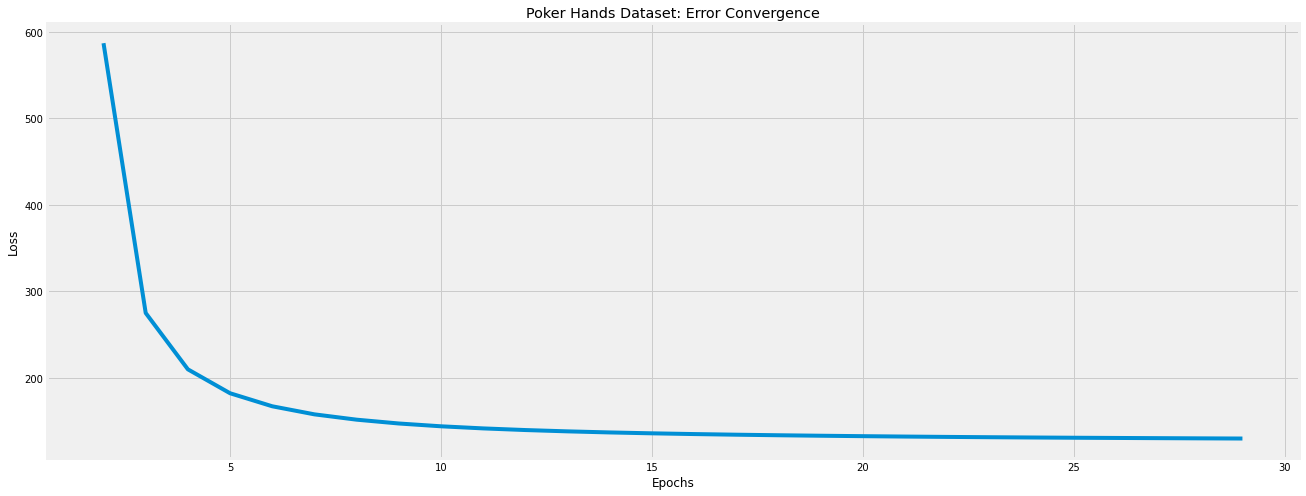

In [10]:
plt.figure(figsize=(20,8))
plt.title("Poker Hands Dataset: Error Convergence")
ax = plt.plot(range(2,30), myNNerror[2:])
plt.ylabel('Loss')
plt.xlabel('Epochs')

**Observations:** As the depth or width of the neural network was increased I had to lower the learning rate or else the network used to either just jump around a value trying to converge or get stuck on a random error.

**Conclusion:** Neural Netowrks are pretty robust for many applications, while the functionality and the math behind the network is all linear but a combination of these linear nodes (ReLU activation) are able to adjust for the non-linearity required for many diffrent applications. The XOR function is an example where a NN is able to create a non-linear boundary where as any linear estimation will fail (a simple perceptron network will fail)

**Future work:** Implementaion of Binary Cross entropy or Cross entropy for the error/loss functions for classification will be an improvement. 
